In [ ]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray

# Set global crs
crs = "EPSG:32638"

# Get the boundary of Tbilisi
tbs = ox.geocode_to_gdf("Tbilisi").to_crs(crs)

# Get the districts
districts = (
    ox.features_from_place(
        "Tbilisi", tags={"boundary": "administrative", "admin_level": "1"}
    )
    .query("place == 'suburb'")
    .to_crs(crs)
)

# Find the landfills
landfill = ox.features_from_place(
    "Tbilisi",
    tags={
        "landuse": "landfill",
    },
).to_crs(crs)

# Lakes and ponds are kept separate from rivers and streams
water = ox.features_from_place(
    "Tbilisi", tags={"water": ["pond", "lake", "reservoir"]}
).to_crs(crs)

# Get the waterways
waterways = ox.features_from_place(
    "Tbilisi", tags={"waterway": ["stream", "canal", "river"]}
).to_crs(crs)

# Get the roads
roads = ox.features_from_place(
    "Tbilisi",
    tags={
        "highway": [
            "motorway",
            "highway",
            "trunk",
            "primary",
            "secondary",
            "tertiary",
            "residential",
        ]
    },
).to_crs(crs)

In [109]:
minx

556506.5896909449

In [ ]:
import pandas as pd

# Load in the topography data
topography = rioxarray.open_rasterio("data/srtm_45_04.tif")

# Ensure the initial CRS is set correctly
topography = topography.rio.write_crs("EPSG:4326")

# Reproject to match our data
topography = topography.rio.reproject("EPSG:32638")

# Clip to bounding box of roads, waterways, tbs, water, landfill, and districts
total_bounds = gpd.GeoDataFrame(
    pd.concat([tbs, districts, landfill, water, waterways, roads])
).total_bounds

minx, miny, maxx, maxy = total_bounds
topography = topography.rio.clip_box(
    minx=minx, miny=miny, maxx=maxx, maxy=maxy, crs=crs
)

# Remove the no data values
topography = topography.where(topography != -32768)

In [ ]:
# # Ensure the geometries are in the same coordinate reference system (CRS)
# landfill = landfill.to_crs(epsg=32638)  # UTM zone 38N for Tbilisi
# waterways = waterways.to_crs(epsg=32638)

# Buffer the landfill geometries by 100 meters
landfill_buffer = landfill.buffer(100)
landfill_buffer = gpd.GeoDataFrame(geometry=landfill_buffer, crs=landfill.crs)

# Perform a spatial join to find waterways within the buffer
waterways_within_100m = gpd.sjoin(
    waterways, landfill_buffer, how="inner", predicate="intersects"
)

In [198]:
from shapely.geometry import Point, LineString


def get_elevation(x, y, topography):
    return topography.sel(x=x, y=y, method="nearest").values.item()


def get_point_nearest_to_landfill(
    row: gpd.GeoDataFrame, landfill_buffer: gpd.GeoDataFrame
):
    """Find the point on the row nearest to any point on the landfill buffer.

    Args:
        row (gpd.GeoDataFrame): The row to find the point on.
        landfill_buffer (gpd.GeoDataFrame): The buffer around the landfill.

    """

    # Initialize the nearest point and distance
    nearest_point = None
    nearest_distance = float("inf")

    # Iterate over the coordinates in the row
    for x, y in row["geometry"].coords:
        point = Point(x, y)

        # Iterate over the buffers around the landfill
        for _, buffer in landfill_buffer.iterrows():
            distance = point.distance(buffer["geometry"])

            # If it's the closets we've seen then update
            if distance < nearest_distance:
                nearest_distance = distance
                nearest_point = point

    return nearest_point


polluted_waterways = []
# Iterate over the waterways within 100 meters of the landfill
for _, row in waterways_within_100m.loc["way"].iterrows():
    elevations = []
    for x, y in row["geometry"].coords:
        elevations.append(get_elevation(x, y, topography))

    # Get the minimum elevation and its coordinates
    min_elevation = min(elevations)
    min_x, min_y = row["geometry"].coords[elevations.index(min_elevation)]

    # Find the point nearest to the landfill
    landfill_point = get_point_nearest_to_landfill(row, landfill_buffer)
    landll_elevation = get_elevation(landfill_point.x, landfill_point.y, topography)

    # We'll create a new GDF, each row will correspond to a waterway
    # but the geometry will be all points in the row from min_elevation to the landfill
    waterway = gpd.GeoDataFrame(
        {
            "elevation": elevations,
            "geometry": [Point(x, y) for x, y in row["geometry"].coords],
        },
        crs=crs,
    )

    # Filter the points to only include those from the minimum elevation to the landfill
    waterway = waterway.loc[waterway["elevation"] >= min_elevation]

    # Slice the waterway at the landfill elevation
    waterway = waterway.loc[waterway["elevation"] <= landll_elevation]

    polluted_waterways.append(waterway)

polluted_waterways = gpd.GeoDataFrame(pd.concat(polluted_waterways))

Text(0.01, 0.01, 'Data sources: OpenStreetMap, NASA SRTM')

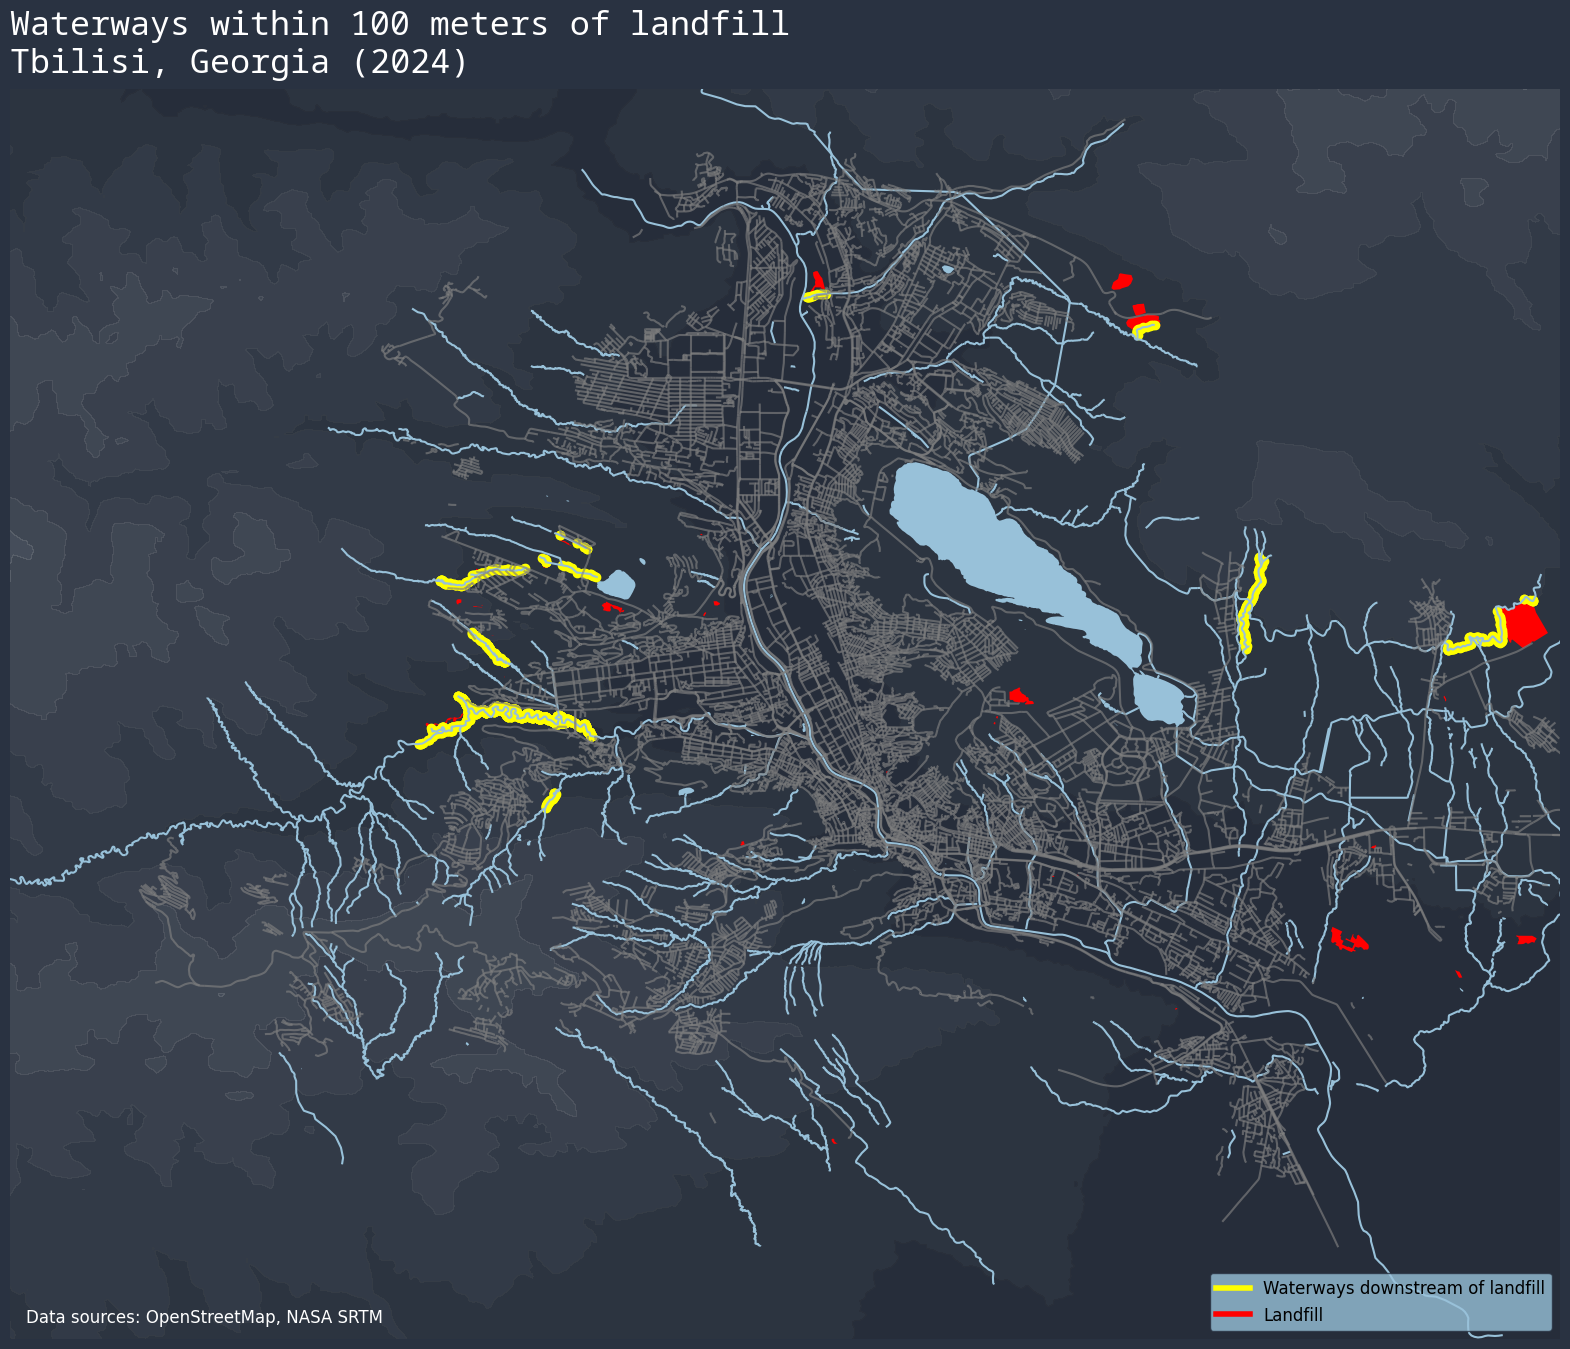

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))

# Get contours
topography_2d = topography.isel(band=0)

# Ensure the data is 2D
topography_2d = topography_2d.squeeze()

# Extract the coordinate arrays
x = topography_2d["x"]
y = topography_2d["y"]

plt.contourf(x, y, topography_2d, levels=5, alpha=0.15, cmap="grey")


water.plot(ax=ax, color="#98c1d9")
waterways.plot(ax=ax, color="#98c1d9", label="Waterways")
roads.plot(ax=ax, color="grey", alpha=0.65)
landfill.plot(ax=ax, color="red", label="Landfill")

polluted_waterways.plot(ax=ax, color="yellow", label="Polluted Waterways")

for spine in ax.spines.values():
    spine.set_visible(False)

fig.patch.set_facecolor("#293241")  # Background for the entire figure
ax.set_facecolor("#293241")

# # Set x and y ticks to None
ax.set_xticks([])
ax.set_yticks([])

# Set the limits explicitly
ax.set_xlim(x.min().values, x.max().values)
ax.set_ylim(y.min().values, y.max().values)


plt.title(
    "Waterways within 100 meters of landfill\nTbilisi, Georgia (2024)",
    loc="left",
    fontsize=24,
    color="white",
    ha="left",
    va="bottom",
    fontdict={"fontname": "Noto Sans Mono"},
)
handles = [
    plt.Line2D(
        [0], [0], color="yellow", lw=4, label="Waterways downstream of landfill"
    ),
    plt.Line2D([0], [0], color="red", lw=4, label="Landfill"),
    # plt.Line2D([0], [0], color="#98c1d9", lw=4, label="Waterways"),
]

plt.legend(
    handles=handles,
    loc="lower right",
    fontsize=12,
    facecolor="#98c1d9",
    edgecolor="#293241",
)

# Plot text in the lower left hand corner with data sources
plt.text(
    0.01,
    0.01,
    "Data sources: OpenStreetMap, NASA SRTM",
    color="white",
    ha="left",
    va="bottom",
    fontsize=12,
    transform=ax.transAxes,
)
# plt.tight_layout(pad=20)

In [ ]:
# Assuming `topography` is your xarray dataset
# Select a 2D slice (e.g., a specific band if the data is 3D)
topography_2d = topography.isel(band=0)

# Ensure the data is 2D
topography_2d = topography_2d.squeeze()

# Extract the coordinate arrays
x = topography_2d["x"]
y = topography_2d["y"]

# Check the shapes of the coordinates and data
print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")
print(f"data shape: {topography_2d.shape}")

x shape: (414,)
y shape: (310,)
data shape: (310, 414)


In [18]:
dem_data = np.ma.masked_where(dem_data == dem.nodata, dem_data)

In [84]:
help(plt.contourf)

Help on function contourf in module matplotlib.pyplot:

contourf(*args, data=None, **kwargs) -> 'QuadContourSet'
    Plot filled contours.

    Call signature::

        contourf([X, Y,] Z, [levels], **kwargs)

    `.contour` and `.contourf` draw contour lines and filled contours,
    respectively.  Except as noted, function signatures and return values
    are the same for both versions.

    Parameters
    ----------
    X, Y : array-like, optional
        The coordinates of the values in *Z*.

        *X* and *Y* must both be 2D with the same shape as *Z* (e.g.
        created via `numpy.meshgrid`), or they must both be 1-D such
        that ``len(X) == N`` is the number of columns in *Z* and
        ``len(Y) == M`` is the number of rows in *Z*.

        *X* and *Y* must both be ordered monotonically.

        If not given, they are assumed to be integer indices, i.e.
        ``X = range(N)``, ``Y = range(M)``.

    Z : (M, N) array-like
        The height values over which the cont